In [13]:
%matplotlib inline
import numpy as np
import sys
import tensorflow as tf
import copy
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
# depending on the classification model use, we might need to import other packages
#from sklearn import svm
#from sklearn.ensemble import RandomForestClassifier
import sklearn
from matplotlib import pyplot as plt
import pickle as pkl
import os 

from datasets import DatasetUCI
from envs import LalEnvTargetAccuracy

from estimator import Estimator
from helpers import Minibatch, ReplayBuffer
from dqn import DQN

In [14]:
from Test_AL import check_performance, check_performance_for_figure

Strategies to test

In [15]:
# Random sampling
rs = True
# Uncertainty sampling
us = True
# LAL-RL learnt strategy on other datasets
rl = True
# LAL-RL learnt strategy on the same dataset (another half)
rl_notransfer = False
# LAL-independent and LAL-iterative strategies
lal = False
# ALBE strategy that learns a combination of rs, us and quire
albe = False
# QUIRE strategy
quire = False

## Experiment parameters

In [25]:
DIRNAME_TRANSFER = './agents/1-australian-logreg-8-to-1/'
DIRNAME_NOTRANSFER = ''
DIRNAME_RESULTS = './AL_results/test-agent-australian.p'

TOLERANCE_LEVEL = 0.98
test_dataset_names = ['australian']

N_STATE_ESTIMATION = 30
SUBSET = -1 # -1 for using all datapoints, 0 for even, 1 for odd
SIZE = 100

N_JOBS = 1 # can set more if we want to parallelise
QUALITY_METHOD = metrics.accuracy_score

N_EXPERIMENTS = 500

Can use different models for classifier
<br>
`LogisticRegression(n_jobs=N_JOBS)` <br>
SVM: <br>
`svm.SVC(probability=True)` <br>
RF: <br>
`RandomForestClassifier(50, oob_score=True, n_jobs=N_JOBS)`

In [26]:
dataset = DatasetUCI(possible_names=test_dataset_names, n_state_estimation=N_STATE_ESTIMATION, subset=SUBSET, size=SIZE)
model = LogisticRegression(n_jobs=N_JOBS)
env = LalEnvTargetAccuracy(dataset, model, quality_method=QUALITY_METHOD, tolerance_level=TOLERANCE_LEVEL)

## Prepare AL methods

#### Methods for random sampling and uncertainty sampling

In [27]:
if rs:
    from Test_AL import policy_random
if us:
    from Test_AL import policy_uncertainty

#### Load RL model

In [28]:
if rl:
    from Test_AL import policy_rl
    tf.reset_default_graph()
    # Load the DQN agent from DIRNAME_TRANSFER
    agent = DQN(experiment_dir=DIRNAME_TRANSFER,
            observation_length=N_STATE_ESTIMATION,
            learning_rate=1e-3,
            batch_size=32,
            target_copy_factor=0.01,
            bias_average=0,
           )

INFO:tensorflow:Restoring parameters from ./agents/1-australian-logreg-8-to-1/checkpoints/model
Loading checkpoint ./agents/1-australian-logreg-8-to-1/checkpoints/model...



#### Load RL model with no transfer

In [29]:
if rl_notransfer:
    from Test_AL import policy_rl
    tf.reset_default_graph()
    # Load the DQN agent from DIRNAME_NOTRANSFER
    agent = DQN(experiment_dir=DIRNAME_NOTRANSFER,
            observation_length=N_STATE_ESTIMATION,
            learning_rate=1e-3,
            batch_size=32,
            target_copy_factor=0.01,
            bias_average=0,
           )

#### Load LAL models

In [30]:
if lal:
    from sklearn.ensemble import RandomForestRegressor
    from Test_AL import policy_LAL
    
    # LAL-INDEPENDENT
    # parameters
    fn = 'LAL-randomtree-simulatedunbalanced-big.npz'
    parameters = {'est': 2000, 'depth': 40, 'feat': 6 }
    # load data
    filename = '../LALfiles/'+fn
    regression_data = np.load(filename)
    regression_features = regression_data['arr_0']
    regression_labels = regression_data['arr_1']
    # build model
    print('building lal model..')
    lal_model1 = RandomForestRegressor(n_estimators = parameters['est'], max_depth = parameters['depth'], 
                                     max_features=parameters['feat'], oob_score=True, n_jobs=8)
    lal_model1.fit(regression_features, np.ravel(regression_labels))    
    print('the model is built!')
    print('oob score = ', lal_model1.oob_score_)

    # LAL-ITERATIVE
    # parameters
    fn = 'LAL-iterativetree-simulatedunbalanced-big.npz'
    parameters = {'est': 1000, 'depth': 40, 'feat': 6 }
    # load data
    filename = '../LALfiles/'+fn
    regression_data = np.load(filename)
    regression_features = regression_data['arr_0']
    regression_labels = regression_data['arr_1']
    # build model
    print('building lal model..')
    lal_model2 = RandomForestRegressor(n_estimators = parameters['est'], max_depth = parameters['depth'], 
                                     max_features=parameters['feat'], oob_score=True, n_jobs=8)
    lal_model2.fit(regression_features, np.ravel(regression_labels))    
    print('the model is built!')
    print('oob score = ', lal_model2.oob_score_)

#### Prepare for ALBE

Depending on the classifier, need to use different adapter <br>
`SklearnProbaAdapter(LogisticRegression(n_jobs=N_JOBS))` for logistic regression or <br>
`SklearnProbaAdapter(svm.SVC(probability=True))` for SVM or <br>
`SklearnProbaAdapter(RandomForestClassifier(50, n_jobs=1))` for RF

In [31]:
if albe:
    import sys
    sys.path.append('./libact/')
    from libact.base.dataset import Dataset
    from libact.query_strategies import QUIRE, UncertaintySampling, ActiveLearningByLearning
    from libact.models import SklearnProbaAdapter
    from Test_AL import policy_ALBE
    
    def reset_albe(dataset, env):
        """Initialises libact to perform ALBE"""
        adapter = SklearnProbaAdapter(LogisticRegression(n_jobs=1)) 
        nolabels = np.array(([None] * len(dataset.train_labels)))
        libactlabels = nolabels
        libactlabels[env.indeces_known] = dataset.train_labels[env.indeces_known]
        trn_ds = Dataset(dataset.train_data, libactlabels)
        # max number of iterations is needed here
        qs = ActiveLearningByLearning(trn_ds, query_strategies=[UncertaintySampling(trn_ds, model=adapter), QUIRE(trn_ds)], T=1000, uniform_sampler=True, model=adapter)
        #qs = QUIRE(trn_ds, model=adapter)
        #qs = ActiveLearningByLearning(trn_ds, query_strategies=[QUIRE(trn_ds)], T=100, uniform_sampler=True, model=adapter)
        return qs, trn_ds

#### Prepare for QUIRE

In [32]:
if quire:
    import sys
    sys.path.append('./libact/')
    from libact.base.dataset import Dataset
    from libact.query_strategies import QUIRE
    from libact.models import SklearnProbaAdapter
    from Test_AL import policy_QUIRE
    
    def reset_quire(dataset, env):
        """"Initialises libact to perform QUIRE"""
        adapter = SklearnProbaAdapter(LogisticRegression(n_jobs=1))
        nolabels = np.array(([None] * len(dataset.train_labels)))
        libactlabels = nolabels
        libactlabels[env.indeces_known] = dataset.train_labels[env.indeces_known]
        trn_ds = Dataset(dataset.train_data, libactlabels)
        # max number of iterations is needed here
        qs = QUIRE(trn_ds, model=adapter)
        return qs, trn_ds

## Run the experiemnts

In [33]:
# Results will be stored in all_results dictionary
all_results = {}
all_scores_rand = []
all_scores_uncert = []
all_scores_rl = []
all_scores_rl_notransfer = []
all_scores_LAL_independant = []
all_scores_LAL_iterative = []
all_scores_ALBE = []
all_scores_QUIRE = []

for experiment in range(N_EXPERIMENTS):
    print(experiment, end=' ')
    # reset the environment
    state, next_action_state = env.reset()
    # run the experiments
    # 1. copy the initial state and environment 
    # so that all strategies start from the same point            
    # 2. done variable indicates when terminal state is reached
    # 3. repeat until terminal state is reached
    # 4. select an action according to the policy
    # to see the prob of selected action: taken_action_state = next_action_state_uncert[:,action]
    # 5. make a step in the environment
    # 6. keep track of the scores in the episode
    if rs:
        env_rand = copy.deepcopy(env)
        state_rand = copy.deepcopy(state)
        done = False
        while not(done):
            action = policy_random(env_rand.n_actions)
            _, _, _, done = env_rand.step(action)
        all_scores_rand.append(env_rand.episode_qualities)
    if us:
        next_action_state_uncert = next_action_state
        env_uncert = copy.deepcopy(env)
        state_uncert = copy.deepcopy(state)
        done = False
        while not(done):
            action = policy_uncertainty(next_action_state_uncert[0,:])
            next_state, next_action_state_uncert, reward, done = env_uncert.step(action)
        all_scores_uncert.append(env_uncert.episode_qualities)
    if rl:
        next_action_state_rl = next_action_state
        env_rl = copy.deepcopy(env)
        state_rl = copy.deepcopy(state)
        done = False
        while not(done):
            action = policy_rl(agent, state_rl, next_action_state_rl)        
            next_state, next_action_state_rl, reward, done = env_rl.step(action)
            state_rl = next_state
        all_scores_rl.append(env_rl.episode_qualities)
    if rl_notransfer:
        next_action_state_rl_notransfer = next_action_state
        env_rl_notransfer = copy.deepcopy(env)
        state_rl_notransfer = copy.deepcopy(state)
        done = False
        while not(done):
            action = policy_rl(agent_notransfer, state_rl_notransfer, next_action_state_rl_notransfer)        
            next_state, next_action_state_rl_notransfer, reward, done = env_rl_notransfer.step(action)
            state_rl_notransfer = next_state
        all_scores_rl_notransfer.append(env_rl_notransfer.episode_qualities)
    if lal:
        next_action_state_LAL_independant = next_action_state
        env_LAL_independant = copy.deepcopy(env)
        state_LAL_independant = copy.deepcopy(state)
        done = False
        while not(done):
            env_LAL_independant.for_lal()
            action = policy_LAL(dataset, env_LAL_independant, lal_model1)
            next_state, next_action_state_LAL_independant, reward, done = env_LAL_independant.step(action)
        all_scores_LAL_independant.append(env_LAL_independant.episode_qualities)
        next_action_state_LAL_iterative = next_action_state
        env_LAL_iterative = copy.deepcopy(env)
        state_LAL_iterative = copy.deepcopy(state)
        done = False
        while not(done):
            env_LAL_iterative.for_lal()
            action = policy_LAL(dataset, env_LAL_iterative, lal_model2)
            next_state, next_action_state_LAL_iterative, reward, done = env_LAL_iterative.step(action)
        all_scores_LAL_iterative.append(env_LAL_iterative.episode_qualities)
    if albe:
        next_action_state_ALBE = next_action_state
        env_ALBE = copy.deepcopy(env)
        state_ALBE = copy.deepcopy(state)
        qs, trn_ds = reset_albe(dataset, env_ALBE)
        done = False
        while not(done):
            action = policy_ALBE(qs, trn_ds, env_ALBE, dataset)
            next_state, next_action_state_ALBE, reward, done = env_ALBE.step(action)
        all_scores_ALBE.append(env_ALBE.episode_qualities)
    if quire:
        next_action_state_QUIRE = next_action_state
        env_QUIRE = copy.deepcopy(env)
        state_QUIRE = copy.deepcopy(state)
        qs, trn_ds = reset_quire(dataset, env_QUIRE)
        done = False
        while not(done):
            action = policy_QUIRE(qs, trn_ds, env_QUIRE, dataset)
            next_state, next_action_state_QUIRE, reward, done = env_QUIRE.step(action)
        all_scores_QUIRE.append(env_QUIRE.episode_qualities)
# record the results
all_results['all_scores_rand'] = all_scores_rand
all_results['all_scores_uncert'] = all_scores_uncert
all_results['all_scores_rl'] = all_scores_rl
all_results['all_scores_rl_notransfer'] = all_scores_rl_notransfer
all_results['all_scores_LAL_independant'] = all_scores_LAL_independant
all_results['all_scores_LAL_iterative'] = all_scores_LAL_iterative
all_results['all_scores_ALBE'] = all_scores_ALBE
all_results['all_scores_QUIRE'] = all_scores_QUIRE
pkl.dump(all_results, open(DIRNAME_RESULTS, "wb" ))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 We ran out of samples!
80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271

## Load the results

In [34]:
all_results = pkl.load(open(DIRNAME_RESULTS, "rb" ) )

In [35]:
all_scores_rand = all_results['all_scores_rand']
all_scores_uncert = all_results['all_scores_uncert']
all_scores_rl = all_results['all_scores_rl']
all_scores_rl_notransfer = all_results['all_scores_rl_notransfer']
all_scores_LAL_independant = all_results['all_scores_LAL_independant']
all_scores_LAL_iterative = all_results['all_scores_LAL_iterative']
all_scores_ALBE = all_results['all_scores_ALBE']
all_scores_QUIRE = all_results['all_scores_QUIRE']

## Check the results

#### Compute the mean duration, it's std, median and max

In [36]:
max_duration = 0
if rs:
    print("Random")
    all_scores_rand, all_durations_rand = check_performance(all_scores_rand)
    max_duration = max(max_duration, max(all_durations_rand))
if us:
    print("Uncertainty")
    all_scores_uncert, all_durations_uncert = check_performance(all_scores_uncert)
    max_duration = max(max_duration, max(all_durations_uncert))
if rl:
    print("RL")
    all_scores_rl, all_durations_rl = check_performance(all_scores_rl)
    max_duration = max(max_duration, max(all_durations_rl))
if rl_notransfer:
    print("RL without transfer")
    all_scores_rl_notransfer, all_durations_rl_notransfer = check_performance(all_scores_rl_notransfer)
    max_duration = max(max_duration, max(all_durations_rl_notransfer))
if lal:
    print("LAL independant")
    all_scores_LAL_independant, all_durations_LAL_independant = check_performance(all_scores_LAL_independant)
    max_duration = max(max_duration, max(all_durations_LAL_independant))
    print("LAL iterative")
    all_scores_LAL_iterative, all_durations_LAL_iterative = check_performance(all_scores_LAL_iterative)
    max_duration = max(max_duration, max(all_durations_LAL_iterative))
if albe:
    print("ALBE")
    all_scores_ALBE, all_durations_ALBE = check_performance(all_scores_ALBE)
    max_duration = max(max_duration, max(all_durations_ALBE))
if quire:
    print("QUIRE")
    all_scores_QUIRE, all_durations_QUIRE = check_performance(all_scores_QUIRE)
    max_duration = max(max_duration, max(all_durations_QUIRE))

Random
mean +/- std is  27.574 +/- 22.173599707760577
median is  21.0
maximum is  97
Uncertainty
mean +/- std is  16.148 +/- 13.437934960402213
median is  12.0
maximum is  98
RL
mean +/- std is  16.126 +/- 12.930820700945475
median is  12.0
maximum is  98


#### Compute the relative scores that can be used to plot the results

In [37]:
scores_relative_rand = check_performance_for_figure(all_scores_rand, max_duration)
scores_relative_uncert = check_performance_for_figure(all_scores_uncert, max_duration)
scores_relative_rl = check_performance_for_figure(all_scores_rl, max_duration)
scores_relative_rl_notransfer = check_performance_for_figure(all_scores_rl_notransfer, max_duration)
scores_relative_LAL_independant = check_performance_for_figure(all_scores_LAL_independant, max_duration)
scores_relative_LAL_iterative = check_performance_for_figure(all_scores_LAL_iterative, max_duration)
scores_relative_ALBE = check_performance_for_figure(all_scores_ALBE, max_duration)
scores_relative_QUIRE = check_performance_for_figure(all_scores_QUIRE, max_duration)

#### Plot the results

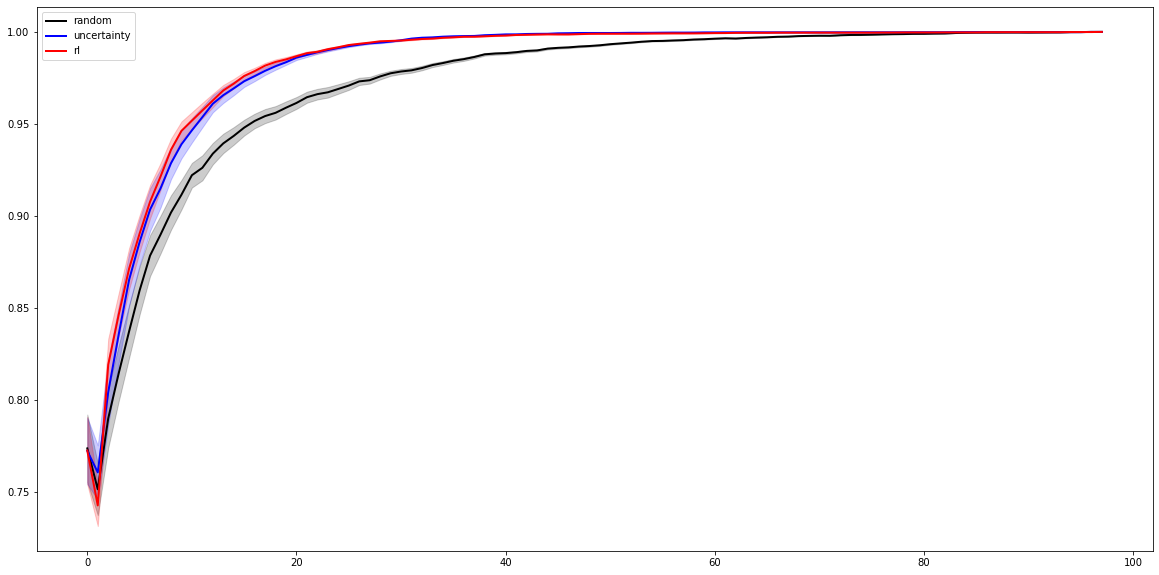

In [38]:
plt.figure(figsize=(20,10))
if rs:
    m_line = np.mean(scores_relative_rand, axis=0)
    var_line = np.var(scores_relative_rand, axis=0)
    plt.plot(m_line, linewidth=2.0, label = 'random', color='k')
    plt.fill_between(range(np.size(m_line)), m_line - var_line, m_line + var_line, color='k', alpha=0.2)
if us:
    m_line = np.mean(scores_relative_uncert, axis=0)
    var_line = np.var(scores_relative_uncert, axis=0)
    plt.plot(m_line, linewidth=2.0, label = 'uncertainty', color='b')
    plt.fill_between(range(np.size(m_line)), m_line - var_line, m_line + var_line, color='b', alpha=0.2)
if rl:
    m_line = np.mean(scores_relative_rl, axis=0)
    var_line = np.var(scores_relative_rl, axis=0)
    plt.plot(m_line, linewidth=2.0, label = 'rl', color='red')
    plt.fill_between(range(np.size(m_line)), m_line - var_line, m_line + var_line, color='red', alpha=0.2)
if rl_notransfer:
    m_line = np.mean(scores_relative_rl_notransfer, axis=0)
    var_line = np.var(scores_relative_rl_notransfer, axis=0)
    plt.plot(m_line, linewidth=2.0, label = 'rl no transfer', color='red')
    plt.fill_between(range(np.size(m_line)), m_line - var_line, m_line + var_line, color='red', alpha=0.2)
if lal:
    m_line = np.mean(scores_relative_LAL_independant, axis=0)
    var_line = np.var(scores_relative_LAL_independant, axis=0)
    plt.plot(m_line, linewidth=2.0, label = 'LAL-independant', color='c')
    plt.fill_between(range(np.size(m_line)), m_line - var_line, m_line + var_line, color='c', alpha=0.2)    
    m_line = np.mean(scores_relative_LAL_iterative, axis=0)
    var_line = np.var(scores_relative_LAL_iterative, axis=0)
    plt.plot(m_line, linewidth=2.0, label = 'LAL-iterative', color='m')
    plt.fill_between(range(np.size(m_line)), m_line - var_line, m_line + var_line, color='m', alpha=0.2)
if albe:
    m_line = np.mean(scores_relative_ALBE, axis=0)
    var_line = np.var(scores_relative_ALBE, axis=0)
    plt.plot(m_line, linewidth=2.0, label = 'ALBE', color='g')
    plt.fill_between(range(np.size(m_line)), m_line - var_line, m_line + var_line, color='g', alpha=0.2)
if quire:
    m_line = np.mean(scores_relative_QUIRE, axis=0)
    var_line = np.var(scores_relative_QUIRE, axis=0)
    plt.plot(m_line, linewidth=2.0, label = 'QUIRE', color='y')
    plt.fill_between(range(np.size(m_line)), m_line - var_line, m_line + var_line, color='y', alpha=0.2)
plt.legend()